<a href="https://colab.research.google.com/github/hughjafro/DS-Sprint-01-Dealing-With-Data/blob/master/Chris_Tolbert_LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
# help(pd.cut)

In [0]:
# https://github.com/hughjafro/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/persons.csv

import random
#dir(random)  # Reminding ourselves what we can do here

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=456.00846099186646, mobile=False), User(purchased=False, time_on_site=107.59937915498853, mobile=True), User(purchased=False, time_on_site=221.91152082260064, mobile=False), User(purchased=False, time_on_site=222.09906423059684, mobile=True), User(purchased=False, time_on_site=230.2862662944303, mobile=True), User(purchased=False, time_on_site=189.85573250938666, mobile=True), User(purchased=False, time_on_site=52.53539863924895, mobile=True), User(purchased=False, time_on_site=30.352359383413116, mobile=True), User(purchased=False, time_on_site=40.43123473763186, mobile=True), User(purchased=False, time_on_site=99.05607721779525, mobile=False)]


In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,456.008461,False
1,False,107.599379,True
2,False,221.911521,False
3,False,222.099064,True
4,False,230.286266,True


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.074096452458931,5.1984494375439585,5.439398714462503,5.755335751414637,6.7006758831216455,7.012552836869253,7.042830315697646,7.0470617698598925,7.3214141902919545,7.349078991057884,...,558.6188250701038,558.9602635702176,562.3276424334427,563.9714862457909,565.6871119459677,565.6996292426747,571.2005985334746,574.4757131011734,575.0117117687282,581.7441307382715
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,1,0,1,1,1,0,...,1,1,1,1,0,1,1,1,1,1
True,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.497, 120.408]","(120.408, 235.742]","(235.742, 351.076]","(351.076, 466.41]","(466.41, 581.744]"
purchased,,,,,
False,258,295,176,48,38
True,74,61,43,2,5


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.497, 120.408]","(120.408, 235.742]","(235.742, 351.076]","(351.076, 466.41]","(466.41, 581.744]"
purchased,,,,,
False,0.777108,0.828652,0.803653,0.96,0.883721
True,0.222892,0.171348,0.196347,0.04,0.116279


In [0]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.904,0.785333
True,0.096,0.214667


In [0]:
#From lecture DS01 - 0104 Trying to load R in Colab
#https://colab.research.google.com/drive/1lmilwq-aKPoGEH6Lvk5-fTsvLkEzrLBe

# Load R to the operating system level (apt) and rpy package is a bridge btwn r and python
!apt install r-base

# rpy package is a bridge btwn r and python
!pip install rpy2

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

# Import raw data from github
persons_data = pd.read_csv('https://raw.githubusercontent.com/hughjafro/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv', index_col=0)

from collections import namedtuple

Person = namedtuple('Person', ['age', 'weight', 'exercise_time'])

persons_data.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


In [0]:
persons_data.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [0]:
persons_data.dtypes

age              int64
weight           int64
exercise_time    int64
dtype: object

In [0]:
print(persons_data[112:123])

     age  weight  exercise_time
112   35     180             63
113   32     169            179
114   59     143            288
115   75     182            117
116   80     170             61
117   61     218             65
118   49     172            212
119   32     129            193
120   70     162            100
121   34     206             36
122   20     106            198


In [0]:
# Create 6 bins based on age min:18, max:80
# Create 6 bins based on weight min:100, max:246
# Use crosstab to see associations weight/age

age_bins = pd.cut(persons_data['age'], 8)
weight_bins = pd.cut(persons_data['weight'], 8)
#pd crosstab(persons_data['weight'], age_bins, normalize='columns')

In [0]:
#pd.crosstab([persons_data['weight'], age_bins], persons_data['exercise_time'], normalize='columns').plot(kind='barh', stacked=True)

# ***** Thiskeeps hanging. Not sure why.
# ***** My bar charts not working out so well

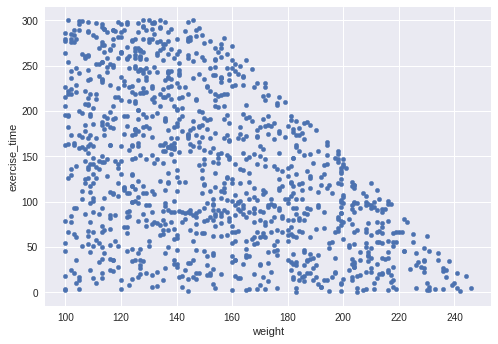

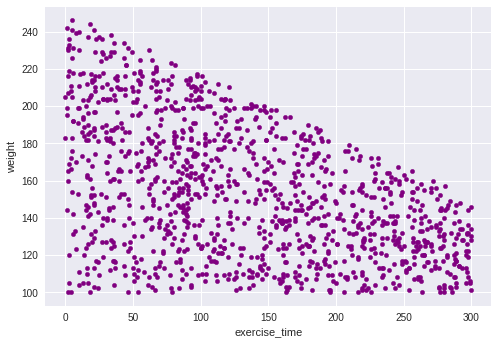

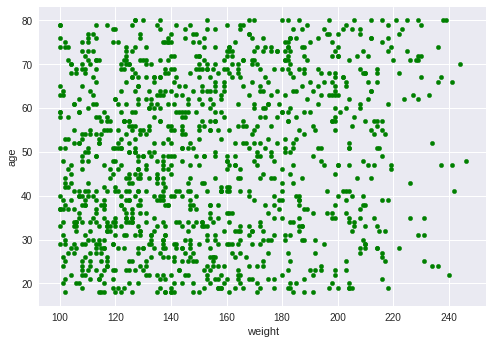

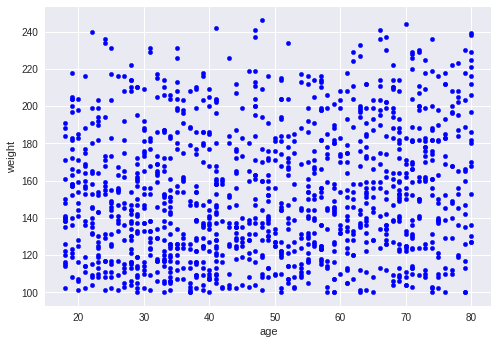

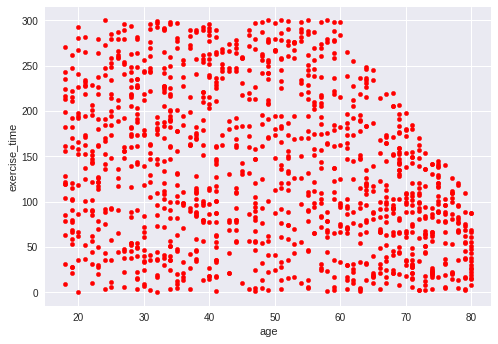

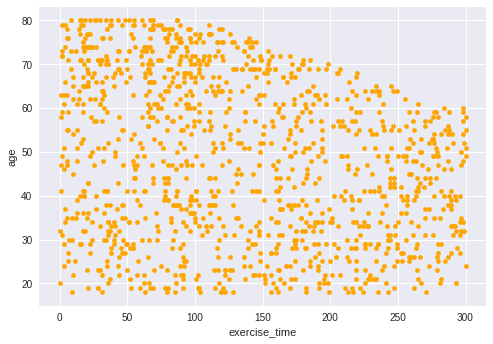

In [0]:
# Plotting scatter and seeing how they relate

persons_data.plot.scatter('weight', 'exercise_time')
persons_data.plot.scatter('exercise_time', 'weight', color='purple')

persons_data.plot.scatter('weight', 'age', color='green')
persons_data.plot.scatter('age', 'weight', color='blue')

persons_data.plot.scatter('age', 'exercise_time', color='red')
persons_data.plot.scatter('exercise_time', 'age', color='orange')


In [0]:
pernew.plot()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1. *** What are the variable types in the data?***
      The variables are Unnamed: 0, age, weight, exercise_time.


2. *** What are the relationships between the variables?***
     I see a relationship between weight and exercise time, they are inversely related. 
     The more you exercise the lower the weight.   Also, exercise and age seem to have an impact 
     after age 58. After 58 exercise time seems to reduce at a more rapid pace. This may have
     more to do with health and energy than anything else.


3. *** Which relationships are "real", and which spurious?***
      I thing age/exercise time and weight/exercise time have real relationships. The other variables
      have more of a spurious relationships.
      Still working on this. Need to watch today's lecture again to determine how to recognize 
      confounding variables.


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)